**<p style = "text-align: center">TRƯỜNG ĐẠI HỌC KHOA HỌC TỰ NHIÊN - ĐẠI HỌC QUỐC GIA TPHCM</p>**

# **<p style = "text-align: center">LẬP TRÌNH KHOA HỌC DỮ LIỆU</p>**
## **<p style = "text-align: center">Đồ án Cuối kì</p>**
## **<p style = "text-align: center">ĐẶT VÀ TRẢ LỜI CÂU HỎI</p>**

### <p style = "text-align: center"> <b>Đề tài:</b> KHÁM PHÁ, THỐNG KÊ CỦA TOP CÁC CA KHÚC TRÊN SPOTIFY</p>
<p style = "text-align: center"> Sinh viên thực hiện </p>

| Mã số sinh viên | Họ và tên |
| --- | --- |
| 20120040 | Nguyễn Quang Gia Bảo |
| 20120127 | Trần Minh Tuấn Kiệt |
| 20120136 | Huỳnh Tuấn Nam |
| 20120158 | Trần Hoàng Anh Phi |

---

# **Import các thư viện**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS


# **Thông tin về dữ liệu**<br>
Dữ liệu được sử dụng trong bài được lấy từ trang: <a href = "https://www.kaggle.com/datasets/yelexa/spotify200?select=final.csv"> https://www.kaggle.com/datasets/yelexa/spotify200?select=final.csv</a><br>
Dataset chứa các ca khúc nằm trong TOP 200 ca khúc hay nhất trong 1 tuần của mỗi quốc gia từ 2021/02/04 ~ 2022/07/14

Theo như file "README.md":
> This directory contains codes that I used to create the dataset: https://www.kaggle.com/datasets/yelexa/spotify200<br><br>To create the dataset, I downloaded the csv files from the 'Weekly Top Songs' charts on Spotify Charts for each country from the week of 2021/02/04 ~ 2022/07/14. For the 'Global' charts, there is data from the week of 2016/12/29 ~ 2022/07/14. I used concat.py to create one combined file for each country, then used data.py to collect additional data for each song from the Spotify API.<br><br>The dataset was aggregated into an interactive dashboard, where you can explore artists and music trends around the world: https://public.tableau.com/app/profile/yejielee/viz/TheModernARExperienceWhichGlobalArtistWillYouSign/ar_dashboard?publish=yes

Đọc dữ liệu từ file csv

In [ ]:
spotify_df = pd.read_csv("./features/processed.csv")

In [ ]:
display(spotify_df)

In [ ]:
pattern = '%Y-%m-%d'
spotify_df['release_date'] = pd.to_datetime(spotify_df['release_date'], format=pattern)
spotify_df['week'] = pd.to_datetime(spotify_df['week'], format=pattern)

***

# **Đưa ra các câu hỏi cần trả lời:**



### **Câu hỏi 1: Dựa vào các đặc trưng về âm thanh của một bài hát, hãy thử dự đoán thể loại nhạc của bài hát đó.**
- Trả lời được câu hỏi này sẽ giúp ta tìm được thể loại nhạc của bài hát bằng các đặc trưng âm thanh.
- Một ứng dụng có thể là tìm ra bài hát qua giai điệu (ví dụ như úng dụng Shazam).

**Hướng giải quyết:**
- Đầu tiên, ta vẽ biểu đồ heatmap để xác định hệ số tương quan giữa các biến.
- Các thuật toán dựa trên cây như XGBoost, có thể xử lý được các biến category biểu diễn onehot. Tuy nhiên, có nhiều thể loại nhạc có tần suất xuất hiện rất thấp, sẽ làm tăng kích thước của ma trận, các giá trị này có ý nghĩa thống kê không đáng kể sẽ làm mô hình cho kết quả không chính xác. Một giải pháp cho vấn đề này có thể là gom nhóm những giá trị này thành một giá trị mới và đặt tên là "Rare".
- Chuẩn hoá các giá trị cho phù hợp với đầu vào của mô hình.
- Thử nghiệm các mô hình.
- Đánh giá kết quả.

In [ ]:
df = spotify_df.drop_duplicates('uri').reset_index(drop=True).copy()

**Lấy ra những "thằng" artist_genre có số lượng lớn hơn `10000`**

In [ ]:
# spotify_df.groupby('artist_genre').filter(lambda x: x['artist_genre'].count() > 10000)['artist_genre'].value_counts()
df = spotify_df[spotify_df.groupby('artist_genre')['artist_genre'].transform('count')>7000].copy() # Viết vậy để lấy dc cái số value count.
df['artist_genre'].value_counts()

<font color=red>*Kể từ đây, ta chỉ dùng sub-dataframe: df để tiếp tục tính cho câu 1*</font>

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer # điền các giá trị thiếu
import numpy as np

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

le = LabelEncoder()
le.fit(df['artist_genre'])
df['categorical_label'] = le.transform(df['artist_genre']) # transform label to numbers

In [ ]:
df['categorical_label'].value_counts()

In [ ]:
le.inverse_transform(df['categorical_label']) # transform label back to original

**Trực quan hoá dữ liệu**

Tìm sự tương quan giữa các cột cường độ âm thanh.

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

audio_cols = ['danceability', 'energy', 'key', 'mode', 'loudness', 'speechiness', 
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
plt.figure(figsize=(12,8))
sns.heatmap(df[audio_cols+['categorical_label']].corr(), annot=True, fmt='.2f')
plt.xticks(rotation=30)
plt.show()

In [ ]:
df[audio_cols+['categorical_label']].hist(bins=50, figsize=(20,20))
# ax.set_title("Hisogram plot", size=15, weight='bold')
plt.show()

In [ ]:
imp = SimpleImputer(missing_values = np.nan, strategy = 'median') # điền các gía trị thiếu bằng median
df[audio_cols] = imp.fit_transform(df[audio_cols])
df[audio_cols].isna().sum()

In [ ]:
new_df = df[audio_cols+['categorical_label']]
for i in new_df.columns:
  print(f'Skewness in {i} =',new_df[i].skew())

skew > 0 => Lệch bên phải ( đuôi bên phải ) - Positive Skewness và ngược lại với skew < 0<br>
https://www.sharkclass.vn/glossary/do-lech-%28skewness%29?lang=en

Các cột có high skew: 
- loudness
- speechiness
- acousticness
- instrucmentalness
- liveness
- duration

In [ ]:
df['loudness_trans'] = np.cbrt(df['loudness'])
df['speechiness_trans'] = np.reciprocal(df['speechiness'])
df['acousticness_trans'] = np.cbrt(df['acousticness'])
df['instrumentalness_trans'] = np.log(df['instrumentalness'].apply(lambda x: x + 0.000001))
df['liveness_trans'] = np.cbrt(df['liveness'])
df['duration_trans'] = np.sqrt(df['duration'])
df['tempo_trans'] = np.cbrt(df['tempo'])

In [ ]:
audio_trans  =['loudness_trans','speechiness_trans','acousticness_trans','instrumentalness_trans','liveness_trans','duration_trans','tempo_trans']
df[audio_trans].hist(bins=50, figsize=(20,20))
# ax.set_title("Hisogram plot", size=15, weight='bold')
plt.show()

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.drop(columns = ['duration','loudness','speechiness','acousticness','instrumentalness','liveness','tempo'], inplace = True)

## **Build model**

In [ ]:
columns = ["artist_names","track_name"]
le = LabelEncoder()
for col in columns:
  df[col] = le.fit_transform(df[col])

In [ ]:
X = df[['danceability', 'energy', 'key',
       'mode', 'valence', 
       'duration_trans','loudness_trans',
        'speechiness_trans','acousticness_trans','instrumentalness_trans','liveness_trans','tempo_trans']]
Y = df['categorical_label']

**Split train test**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=11)

In [ ]:
# !pip install xgboost

**Standard Scaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
scaler = StandardScaler()
normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)

Xgbclassifier = xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=1000, 
                        num_classes=21, random_state=5).fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_pred = Xgbclassifier.predict(normalized_x_test)

XGBAcc = accuracy_score(y_pred,y_test)
print('XG Boost accuracy is: {:.2f}%'.format(XGBAcc*100))

In [ ]:
Xgbclassifier.save_model('xgb_model.json')

In [ ]:
Xgbclassifier.best_ntree_limit

**Normalizer**

In [ ]:
from sklearn.preprocessing import Normalizer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

normalizer = Normalizer()
normalized_x_train = pd.DataFrame(normalizer.fit_transform(x_train), columns = x_train.columns)

Xgbclassifier = xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=1000, 
                        num_classes=14, random_state=5).fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_pred = Xgbclassifier.predict(normalized_x_test)

XGBAcc = accuracy_score(y_pred,y_test)
print('XG Boost accuracy is: {:.2f}%'.format(XGBAcc*100))

**Logistic Regression and MinMaxScaler**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)

LR = LogisticRegression(solver='newton-cg', multi_class = 'multinomial',random_state = 7).fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_pred = LR.predict(normalized_x_test)

from sklearn.metrics import accuracy_score
LRAcc = accuracy_score(y_pred,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression(solver='liblinear').fit(normalized_x_train, y_train)
normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_pred = LR.predict(normalized_x_test)

LRAcc = accuracy_score(y_pred,y_test) # Calculate accuracy
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)

RFclassifier = RandomForestClassifier(max_leaf_nodes = 30,random_state = 3).fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_pred = RFclassifier.predict(normalized_x_test)

from sklearn.metrics import accuracy_score
RFAcc = accuracy_score(y_pred,y_test)
print('Random Forest accuracy is: {:.2f}%'.format(RFAcc*100))

***

In [ ]:
text = ', '.join(spotify_df['artist_genre'])
word_cloud = WordCloud(width=3000, 
                       height=2000, 
                       random_state=1, 
                       background_color='pink', 
                     #   colormap='Pastel1',
                       collocations=False,
                       stopwords=', ').generate(text)

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
!git ls-tree -r --name-only --full-name modeling

In [ ]:
from collections import Counter
def reduce_categories(col, threshold=0.85):
    threshold_value = int(threshold*len(col))
    reduced_cats = []
    s = 0
    counts = Counter(col)
    
    for i, j in counts.most_common():
        s+=dict(counts)[i]
        reduced_cats.append(i)
        if s>=threshold_value:
            break
    reduced_cats.append('Other')
    
    new_col=col.apply(lambda x: x if x in reduced_cats else 'Other')
    return new_col, reduced_cats

col, cate = reduce_categories(spotify_df['artist_genre'])
col.value_counts()

### **Trả lời câu hỏi 2**: Thời gian nào trong năm thì bài hát dễ 'lên hạng'?

In [ ]:
spotify_df.sample(5)

In [ ]:
standard_prev_rank = spotify_df['previous_rank'].apply(lambda x: 200 if x == -1 else x)
spotify_df['rank_up'] = standard_prev_rank - spotify_df['rank']

In [ ]:
spotify_df[spotify_df['country']=='Vietnam'][spotify_df['rank']==1]#.value_counts()

In [ ]:
trending = spotify_df[spotify_df['country']=='Vietnam'][spotify_df['rank_up']==spotify_df['rank_up'].max()]
trending

In [ ]:
x = spotify_df[spotify_df['country']=='Vietnam'].groupby(spotify_df['week'].dt.month)['rank_up'].value_counts()
display(x)

In [ ]:
pd.DataFrame(x.to_frame().rename(columns={'rank_up': 'counts'}).reset_index().sort_values(by=['rank_up']))

Check một bài hát đã ở trong top tuần này có ở trong top tuần khác không?

In [ ]:
spotify_df[spotify_df['country'] == 'Global']

In [ ]:
spotify_df.groupby('week')['track_name'].value_counts().to_frame()

---

### **Câu hỏi 3**: Ca khúc nào có được nhiều sự yêu thích ở các Quốc gia ?

Ca khúc được yêu thích dựa trên các yếu tố như: <br>
+ Được lên top 10 Quốc gia.
+ Có được thời gian trong top lâu nhất liên tục qua các quá trình cập nhật.

Đầu tiên xét ở một quốc gia nhỏ như Việt Nam trước khi đến toàn bộ Quốc gia của dataset đề cập.

Kiểm tra lại các cột trước khi tiến hành trả lời câu hỏi.

In [ ]:
spotify_df.columns

In [ ]:
cols = ["uri", "artist_names", "track_name", "week", "streams", "country"]
spotify_df[cols].info()

Không có dòng thiếu. Tiến hành trả lời câu hỏi.


**Bước 1**: Chọn các bài hát thuộc Quốc gia Việt Nam

In [ ]:
def song_in_country(country):
    return spotify_df[spotify_df.country == country]

In [ ]:
song_in_vietnam_df = song_in_country("Vietnam")

**Bước 2**: Chọn các bài hát được đưa lên top 1 Việt Nam

In [ ]:
def song_in_top_10(df):
    return df[df["rank"] <= 10]

In [ ]:
top10_df = song_in_top_10(song_in_vietnam_df)

**Bước 3**: Tạo một mảng đánh dấu lại các ngày được lên top10

In [ ]:
group_weeks = top10_df.groupby("uri")["week"].apply(lambda grp: list(set(grp))).reset_index()

In [ ]:
weeks = sorted(top10_df.week.unique())

In [ ]:
def check_week_series(aWeeks):
    aDates = np.zeros(len(weeks))
    lIndex = [weeks.index(week) for week in aWeeks] # get index from "weeks"
    aDates[lIndex] = 1
    return aDates

In [ ]:
# group_weeks["check_date"] = group_weeks.apply(lambda x: check_date_series(x.week), axis =1)
group_weeks["check_week"] = group_weeks.week.apply(check_week_series)
group_weeks

**Bước 4**: Tính tổng số ngày lên top10 liên tục

In [ ]:
def num_week_on_top_continuously(aCheckWeek):
    lCheckWeek = aCheckWeek.tolist()
    if 0 in lCheckWeek:
        idx1 = lCheckWeek.index(1)
        lFromIndex = lCheckWeek[idx1:]
        if 0 in lFromIndex:
            idx0 = lFromIndex.index(0)
            num_week_on_top = sum(lFromIndex[:idx0])
        else:
            num_week_on_top = len(lFromIndex)
    else:
        num_week_on_top = len(lCheckWeek)
    return num_week_on_top

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
group_weeks["num_week_on_top_continuously"] = group_weeks.check_week.apply(num_week_on_top_continuously)
group_weeks

In [ ]:
top_uri = group_weeks.loc[group_weeks.num_week_on_top_continuously == group_weeks.num_week_on_top_continuously.max()]["uri"].values[0]
top_uri

In [ ]:
favorite_song_df = top10_df[top10_df.uri == top_uri]
favorite_song_df

Áp dụng cho lại thử cho một Quốc Gia bất kỳ

In [ ]:
# spotify_df.country.unique().tolist()

In [ ]:
def favorite_song_in_country(country):
    song_in_country_df = song_in_country(country)
    top10_df = song_in_top_10(song_in_country_df)
    group_weeks = top10_df.groupby("uri")["week"].apply(lambda grp: list(set(grp))).reset_index()
    weeks = sorted(top10_df.week.unique())
    group_weeks["check_week"] = group_weeks.week.apply(check_week_series)
    group_weeks["num_week_on_top_continuously"] = group_weeks.check_week.apply(num_week_on_top_continuously)
    top_uri = group_weeks.loc[group_weeks.num_week_on_top_continuously == group_weeks.num_week_on_top_continuously.max()]["uri"].values[0]
    favorite_song_df = top10_df[top10_df.uri == top_uri]
    return favorite_song_df

In [ ]:
favorite_song_in_country("Argentina")

---

### **Câu 4**: Ca sĩ thuộc nhiều bài top hit nhất ở một Quốc Gia trong mùa hè năm 2022?

Ca sĩ thuộc nhiều bài top hit: <br>
+ Là ca sĩ hát nhiều bài trong top nhất. <br>

Mùa hè năm 2022:<br>
+ Những tuần thuộc tháng 4 5 6.

In [ ]:
spotify_df.columns

In [ ]:
cols_work = ["uri", "artist_names", "rank", "week", "country"]
df = spotify_df[cols_work]

**Bước 1**: Lọc những bài hát thuộc mùa hè năm 2022

In [ ]:
summer_song_df = df.loc[(df["week"].dt.month > 3) & (df["week"].dt.month < 7) & (df["week"].dt.year == 2022)]
# summer_song_df

**Bước 2**: Tách cột tên thành từng dòng các nghệ sĩ của bài hát:

In [ ]:
summer_song_df.artist_names

In [ ]:
summer_song_df["artist_names"]= summer_song_df.artist_names.apply(lambda x: x.split(", "))

In [ ]:
summer_song_df

Dùng hàm pd.DataFrame.explode để khai triển các tên trong list thành 1 row khác

In [ ]:
summer_song_df = summer_song_df.explode("artist_names")

**Bước 3**: Tính số lượng bài hát mà ca sĩ đó tham gia.

In [ ]:
count_singer_in_summer_df = summer_song_df.groupby("country")["artist_names"].value_counts().to_frame().rename(columns = {"artist_names": "count"}).reset_index()
count_singer_in_summer_df

**Bước 4**: Tìm index có giá trị bằng với giá trị lớn nhất của mỗi group `country`<br>
+ Tạo biến `idx` để chứa 1 Series `bool` tìm các vị trí trùng với vị trí `count` lớn nhất của mỗi group `country`

In [ ]:
idx = count_singer_in_summer_df.groupby("country")["count"].transform("max") == count_singer_in_summer_df["count"]

In [ ]:
favorite_artist_in_summer_df = count_singer_in_summer_df[idx].set_index("country")

In [ ]:
favorite_artist_in_summer_df

Kiểm tra lại kết quả cho chắc

In [ ]:
summer_song_df[(summer_song_df.country == "Argentina") & (summer_song_df.artist_names == "Bad Bunny")]

---

### **Câu 5**: Ca sĩ nào có tầm ảnh hưởng lớn nhất toàn thế giới ?

- Ca sĩ có tầm hưởng tới thế giới: <Br>
Là ca sĩ đạt tổng số lượt stream nhất định tính trên phương diện toàn thế giới
- Tầm ảnh hưởng lớn nhất thế giới: <Br>
Bài hát giúp cho chiếm `%` stream lớn nhất trên giúp ca sĩ đó đạt được top 1 thế giới

**Bước 1**: Tìm ra ca sĩ nào đang có số lượng stream cao nhất toàn thế giới

In [82]:
info_streams = spotify_df[['uri', 'artist_names', 'streams', 'track_name']]
view_info_artist = pd.DataFrame(info_streams.groupby(['artist_names'])['streams'].sum().sort_values(ascending= False)).reset_index()
view_info_artist.iloc[[0]]

,artist_names,streams
0,Ed Sheeran,13643869470


Vậy có thể thấy `Ed Sheeran` chính là ca sĩ có tổng số lượng stream cao nhất thế giới

**Bước 2**: Lấy thông tin số lượng streams của bài hát mà `Ed Sheeran` hát

In [84]:
artist_name = info_streams.groupby(['artist_names'])['streams'].sum().sort_values(ascending= False).idxmax()
info_song = info_streams.loc[info_streams['artist_names'] == artist_name]
info_song

,uri,artist_names,streams,track_name
415,spotify:track:3rmo8F54jFF8OgYsqTxm5d,Ed Sheeran,244760,Bad Habits
554,spotify:track:6PQ88X9TkUIAUIZJHW2upE,Ed Sheeran,381023,Bad Habits
708,spotify:track:3rmo8F54jFF8OgYsqTxm5d,Ed Sheeran,220457,Bad Habits
925,spotify:track:6PQ88X9TkUIAUIZJHW2upE,Ed Sheeran,395016,Bad Habits
1016,spotify:track:3rmo8F54jFF8OgYsqTxm5d,Ed Sheeran,341046,Bad Habits
...,...,...,...,...
1103424,spotify:track:7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,28705,Shape of You
1103503,spotify:track:3rmo8F54jFF8OgYsqTxm5d,Ed Sheeran,49708,Bad Habits
1103509,spotify:track:50nfwKoDiSYg8zOCREWAm5,Ed Sheeran,46792,Shivers
1103625,spotify:track:3rmo8F54jFF8OgYsqTxm5d,Ed Sheeran,48632,Bad Habits


**Bước 3**: Mô hình hoá dữ liệu dể dễ quan sát hơn

[Text(0.5, 0, 'Streams'), Text(0, 0.5, 'Songs')]

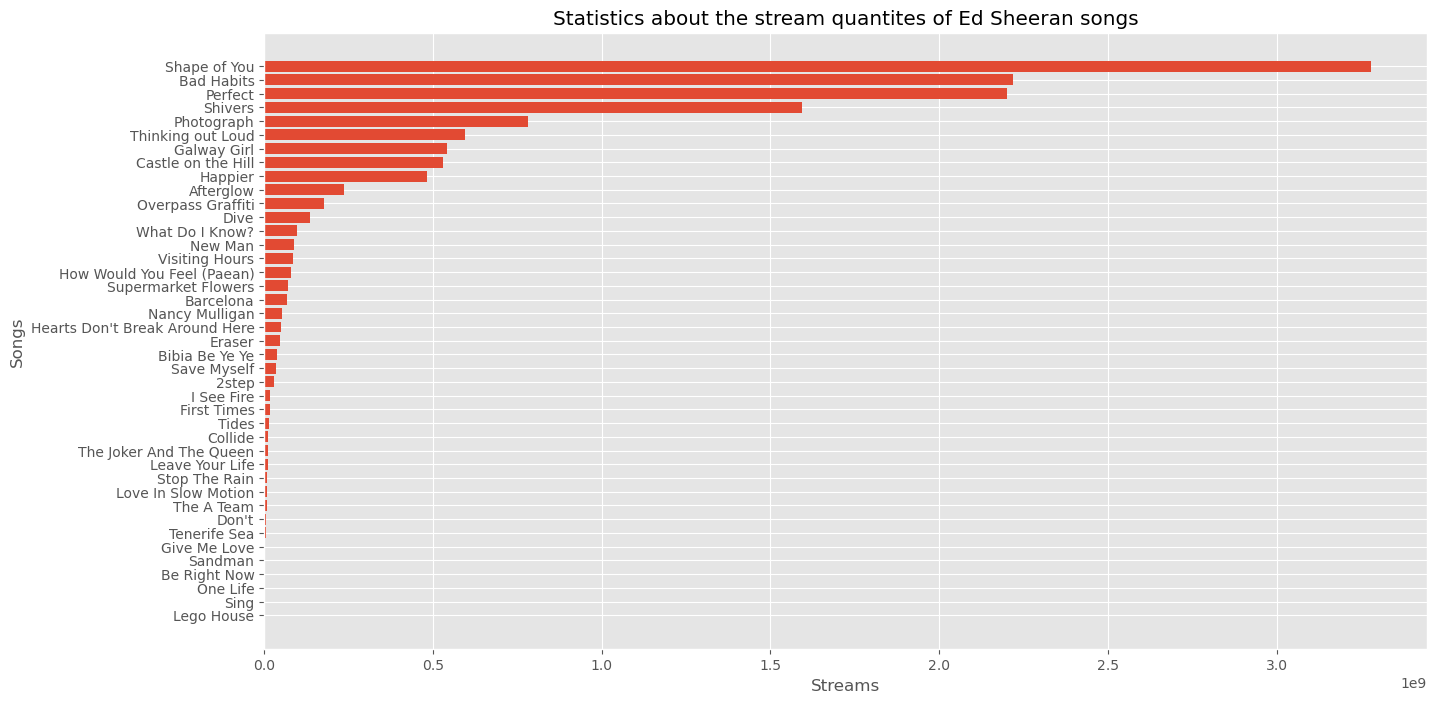

In [109]:
bar_df = info_song.groupby(['track_name'])['streams'].sum().sort_values(ascending=True)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(bar_df.index, bar_df.values)
ax.set_title('Statistics about the stream quantites of Ed Sheeran songs')
ax.set(xlabel = 'Streams', ylabel = 'Songs')

Vậy có thể thấy nhờ vào bài hát `Shape of You` mà giúp Ed Sheeran đạt được 1 số lượt streams lớn để trở thành ca sĩ có tầm ảnh hưởng nhất thế giới.